# Python notebook for case-study run on the CICIDS security dataset, by Will Bridges

# Code set-up: Imports, Packages, Environment variables, and Methods

The software versions used are:
- The Python3 version used for this work is: Python 3.8.x
- The scikit-learn version used is: scikit-learn 0.24.0
- The seaborn version used is: 0.11.1
- The Pandas version used is: 1.1.5 (although 1.2.0 was released recently, this should also work)

Before running, please run these commands via pip, in the terminal:
- pip install pandas
- pip install scikit-learn
- pip install scikit-plot
- pip install seaborn

### Imports

In [1]:
%matplotlib inline
import os # For accessing Python Modules in the System Path (for accessing the Statistical Measures modules).
import pandas as pd # For DataFrames, Series, and reading csv data in.
import seaborn as sns # Graphing, built ontop of MatPlot for ease-of-use and nicer diagrams.
import matplotlib.pyplot as plt # MatPlotLib for graphing data visually. Seaborn more likely to be used.
import numpy as np # For manipulating arrays and changing data into correct formats for certain libraries
import sklearn # For Machine Learning algorithms
from sklearn.decomposition import PCA # For PCA dimensionality reduction technique
from sklearn.preprocessing import StandardScaler # For scaling to unit scale, before PCA application

### Methods

Clean_dataset method is used to remove infinite and Nan value errors (in the original dataset), which was causing errors in the PCA transform step.

Code reference: https://stackoverflow.com/a/46581125 (with a minor change = removed the conversion to float64 type)

In [2]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]

### Useful environment variables

In [3]:
# 'Reduced dimensions' variable for altering the number of PCA principal components. Can be altered for needs.
dimensions_num_for_PCA = 30

# Max number of permutations to run. Can be altered for needs.
permutation_num = 10

### Importing the dataset into Pandas.DataFrame and showing the top 5 entries via 'df.head()'

In [4]:
Friday_Morning_Data = pd.read_csv('Friday-WorkingHours-Morning.pcap_ISCX.csv')
df = Friday_Morning_Data.copy()
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3268,112740690,32,16,6448,1152,403,0,201.5,204.724205,...,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,BENIGN
1,389,112740560,32,16,6448,5056,403,0,201.5,204.724205,...,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,BENIGN
2,0,113757377,545,0,0,0,0,0,0.0,0.000000,...,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,BENIGN
3,5355,100126,22,0,616,0,28,28,28.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,0,54760,4,0,0,0,0,0,0.0,0.000000,...,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


### Fixing column name issues

Because of Excel being used to create the csv, the column headings/ names contain whitespace padding, incorrect capitalisation, etc... which makes it difficult to correctly select by column names. This piece of code below just removes these issues. 

Code Reference: https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

In [5]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df.head()

<ipython-input-5-6efba12d8d07>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')


,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,3268,112740690,32,16,6448,1152,403,0,201.5,204.724205,...,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,BENIGN
1,389,112740560,32,16,6448,5056,403,0,201.5,204.724205,...,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,BENIGN
2,0,113757377,545,0,0,0,0,0,0.0,0.000000,...,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,BENIGN
3,5355,100126,22,0,616,0,28,28,28.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,0,54760,4,0,0,0,0,0,0.0,0.000000,...,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


### Looking at the original data types

In [6]:
df.dtypes

destination_port                 int64
flow_duration                    int64
total_fwd_packets                int64
total_backward_packets           int64
total_length_of_fwd_packets      int64
                                ...   
idle_mean                      float64
idle_std                       float64
idle_max                         int64
idle_min                         int64
label                           object
Length: 79, dtype: object

### Fixing issues with ScikitLearn's PCA transform on this dataset

Without cleaning the dataset, the PCA transform was throwing this error: 
- "sklearn error ValueError: Input contains NaN, infinity or a value too large for dtype('float64')". 

It isn't obvious which attribute and/ or data point is causing this as the input dataset is supposed to be fully clean with no Nan or erroneous values. Also, there are too many attributes to manually search through to check this too. Thus, a quick solution via stackoverflow was found to work (see the 'clean_dataset(df)' method)

Some rows have been removed by the cleaning, indicating that some rows did have issues/ errors within them.

In [7]:
df_cleaned = df.copy()
df_cleaned = clean_dataset(df_cleaned) # see methods at top of notebook
df_cleaned

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,3268,112740690,32,16,6448,1152,403,0,201.5,204.724205,...,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,BENIGN
1,389,112740560,32,16,6448,5056,403,0,201.5,204.724205,...,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,BENIGN
2,0,113757377,545,0,0,0,0,0,0.0,0.000000,...,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,BENIGN
3,5355,100126,22,0,616,0,28,28,28.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,0,54760,4,0,0,0,0,0,0.0,0.000000,...,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191028,53,61452,4,2,180,354,45,45,45.0,0.000000,...,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
191029,53,171,2,2,80,272,40,40,40.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
191030,53,222,2,2,90,354,45,45,45.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
191031,123,16842,1,1,48,48,48,48,48.0,0.000000,...,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


Resetting indexes since rows have been dropped.

In [8]:
df_cleaned = df_cleaned.reset_index()
# Removing un-needed index column added by reset_index method
df_cleaned.drop('index', axis=1, inplace=True)
df_cleaned

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,3268,112740690,32,16,6448,1152,403,0,201.5,204.724205,...,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,BENIGN
1,389,112740560,32,16,6448,5056,403,0,201.5,204.724205,...,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,BENIGN
2,0,113757377,545,0,0,0,0,0,0.0,0.000000,...,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,BENIGN
3,5355,100126,22,0,616,0,28,28,28.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,0,54760,4,0,0,0,0,0,0.0,0.000000,...,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190906,53,61452,4,2,180,354,45,45,45.0,0.000000,...,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
190907,53,171,2,2,80,272,40,40,40.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
190908,53,222,2,2,90,354,45,45,45.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
190909,123,16842,1,1,48,48,48,48,48.0,0.000000,...,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


### Considerations before PCA can be used correctly (before Data Preparation feature selection via PCA)
Looking at this resource and many others (https://towardsdatascience.com/pca-is-not-feature-selection-3344fb764ae6), it can be seen that PCA can, quite easily, be used incorrectly without proper consideration and/ or understanding.

From the resource:
- "A common mistake new data scientists make is to apply PCA to non-continuous variables. While it is technically possible to use PCA on discrete variables, or categorical variables that have been one hot encoded variables, you should not. Simply put, if your variables don’t belong on a coordinate plane, then do not apply PCA to them"

Thus, PCA should **only** be applied to the numeric features- which **must** be scaled down to unit scale.

### What features should be included from PCA, and why?

Looking at the list of feature names in the dataset (shown below), one can see that all other features should be of numeric type (with domain knowledge). They're all currently numeric type (either float or int). Consequently, PCA **can be** fully applied after scaling them all to unit scale.

In [9]:
df.columns.tolist()

['destination_port',
 'flow_duration',
 'total_fwd_packets',
 'total_backward_packets',
 'total_length_of_fwd_packets',
 'total_length_of_bwd_packets',
 'fwd_packet_length_max',
 'fwd_packet_length_min',
 'fwd_packet_length_mean',
 'fwd_packet_length_std',
 'bwd_packet_length_max',
 'bwd_packet_length_min',
 'bwd_packet_length_mean',
 'bwd_packet_length_std',
 'flow_bytes/s',
 'flow_packets/s',
 'flow_iat_mean',
 'flow_iat_std',
 'flow_iat_max',
 'flow_iat_min',
 'fwd_iat_total',
 'fwd_iat_mean',
 'fwd_iat_std',
 'fwd_iat_max',
 'fwd_iat_min',
 'bwd_iat_total',
 'bwd_iat_mean',
 'bwd_iat_std',
 'bwd_iat_max',
 'bwd_iat_min',
 'fwd_psh_flags',
 'bwd_psh_flags',
 'fwd_urg_flags',
 'bwd_urg_flags',
 'fwd_header_length',
 'bwd_header_length',
 'fwd_packets/s',
 'bwd_packets/s',
 'min_packet_length',
 'max_packet_length',
 'packet_length_mean',
 'packet_length_std',
 'packet_length_variance',
 'fin_flag_count',
 'syn_flag_count',
 'rst_flag_count',
 'psh_flag_count',
 'ack_flag_count',
 'ur

### Data Preparation: PCA Dimension reduction and scaling (Hughes' Phenomenon)

PCA acts to reduce the dimensions/ search space of the dataset as much as possible, while trying to maintain the most information possible e.g. It can easily reduce the dimensionality by more than half, while still maintaining 99% of the original data's information- it does this by extracting out the most important information/ trends/ spread (variance) of each dimension/ attribute- into n 'principal components'.

More formally: PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance.

##### *Key note:* 
"**PCA centers but does not scale the input data** for each feature before applying the SVD. The optional parameter whiten=True makes it possible to project the data onto the singular space while scaling each component to unit variance. This is often useful if the models down-stream make strong assumptions on the isotropy of the signal: this is for example the case for **Support Vector Machines with the RBF kernel** and the **K-Means clustering algorithm**." (https://scikit-learn.org/stable/modules/decomposition.html#pca)

PCA still works without standardizing the features to unit scale **but tranforming to unit scale should still be done** to prevent large variance features from having an over-bearing affect on other lower variance features (via something like StandardScaler here https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). 

This is **particularly important with this dataset**, as some features have massively wide variances and others do not (e.g. the 'idle_std' values can range from e+06, all the way to zero).

In [10]:
# Saving the label attribute before dropping it.
df_labels = df_cleaned['label']
# Shows all the possible labels/ classes a model can predict.
# Need to alter these to numeric 0, 1, etc... for model comprehension (e.g. pd.get_dummies()).
df_labels.unique()

array(['BENIGN', 'Bot'], dtype=object)

The label column has to be removed as you wouldn't want this involved in the PCA process. It can be concatted back with the PCA tranformed dataframe.

In [11]:
# Axis=1 means columns. Axis=0 means rows. inplace=False means that the original 'df' isn't altered.
df_no_labels = df_cleaned.drop('label', axis=1, inplace=False)
# Getting feature names for the StandardScaler process
df_features = df_no_labels.columns.tolist()
# Printing out Dataframe with no label column, to show successful dropping
df_no_labels

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,3268,112740690,32,16,6448,1152,403,0,201.5,204.724205,...,15,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000
1,389,112740560,32,16,6448,5056,403,0,201.5,204.724205,...,15,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000
2,0,113757377,545,0,0,0,0,0,0.0,0.000000,...,0,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997
3,5355,100126,22,0,616,0,28,28,28.0,0.000000,...,21,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0
4,0,54760,4,0,0,0,0,0,0.0,0.000000,...,0,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190906,53,61452,4,2,180,354,45,45,45.0,0.000000,...,3,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0
190907,53,171,2,2,80,272,40,40,40.0,0.000000,...,1,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0
190908,53,222,2,2,90,354,45,45,45.0,0.000000,...,1,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0
190909,123,16842,1,1,48,48,48,48,48.0,0.000000,...,0,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0


### Using StandardScaler to transform features into unit scale, ready for PCA

Code references: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60 & https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [12]:
# x = df_no_labels.loc[:, df_features].values
df_scaled = StandardScaler().fit_transform(df_no_labels)
# Converting back to dataframe
df_scaled = pd.DataFrame(data = df_scaled, columns = df_features)
df_scaled

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,-0.208443,3.291795,0.016543,-0.000286,0.737720,-0.008219,0.411408,-0.570375,1.277916,0.962640,...,0.004463,1.005074,-0.098639,-0.109209,-0.137345,-0.072847,0.877130,0.149265,0.866895,0.849955
1,-0.380963,3.291791,0.016543,-0.000286,0.737720,-0.007042,0.411408,-0.570375,1.277916,0.962640,...,0.004463,1.005074,-0.098684,-0.109202,-0.137382,-0.072923,0.877130,0.149260,0.866895,0.849955
2,-0.404273,3.324902,0.483712,-0.011095,-0.075734,-0.008567,-0.315197,-0.570375,-0.443399,-0.312913,...,-0.009872,-4.009835,10.681442,14.744955,14.028865,-0.073272,0.596286,3.118198,1.175767,0.128155
3,-0.083383,-0.376184,0.007436,-0.011095,0.001978,-0.008567,-0.264713,0.097560,-0.204209,-0.312913,...,0.010197,1.005074,-0.099053,-0.109234,-0.137630,-0.073297,-0.282251,-0.080798,-0.284355,-0.273412
4,-0.404273,-0.377661,-0.008956,-0.011095,-0.075734,-0.008567,-0.315197,-0.570375,-0.443399,-0.312913,...,-0.009872,-4.009835,-0.099053,-0.109234,-0.137630,-0.073297,-0.282251,-0.080798,-0.284355,-0.273412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190906,-0.401097,-0.377444,-0.008956,-0.009744,-0.053026,-0.008460,-0.234062,0.503093,-0.058986,-0.312913,...,-0.007005,-0.875517,-0.099053,-0.109234,-0.137630,-0.073297,-0.282251,-0.080798,-0.284355,-0.273412
190907,-0.401097,-0.379439,-0.010777,-0.009744,-0.065642,-0.008485,-0.243077,0.383819,-0.101699,-0.312913,...,-0.008917,1.005074,-0.099053,-0.109234,-0.137630,-0.073297,-0.282251,-0.080798,-0.284355,-0.273412
190908,-0.401097,-0.379437,-0.010777,-0.009744,-0.064380,-0.008460,-0.234062,0.503093,-0.058986,-0.312913,...,-0.008917,1.005074,-0.099053,-0.109234,-0.137630,-0.073297,-0.282251,-0.080798,-0.284355,-0.273412
190909,-0.396902,-0.378896,-0.011688,-0.010420,-0.069679,-0.008552,-0.228654,0.574657,-0.033359,-0.312913,...,-0.009872,-0.875517,-0.099053,-0.109234,-0.137630,-0.073297,-0.282251,-0.080798,-0.284355,-0.273412


### Plotting principle component variance

A scree plot displays the variance explained by each principal component within the analysis.

**The plot below shows that using the first 30 PCA components actually describes most/ all of the variation (information) within the original data. This is a huge dimension reduction from the initial 78 features, down to just 30.**

Thus, looking at the Environment Variables (at the top of the notebook), the 'dimensions_num_for_PCA' variable will be set to **30** based upon this evidence.

(Code reference: https://medium.com/district-data-labs/principal-component-analysis-with-python-4962cd026465)

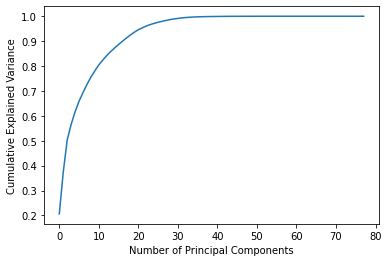

In [13]:
pca_test = PCA().fit(df_scaled)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

### Now fitting and transforming the data with PCA

Thus, the optimal number of principle components is set to the environment variable and this is now used to produce the appropriate multi-dimensional principle component array. This will be formatted back to a Pandas dataframe afterwards.

References: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html and https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [14]:
pca = PCA(n_components=dimensions_num_for_PCA)
principal_components = pca.fit(df_scaled).transform(df_scaled)
principal_components

array([[ 4.09274929e+00, -1.03935146e+00,  1.26069052e+00, ...,
         4.05335511e-02,  1.06574238e+00, -2.21165062e-01],
       [ 4.44413610e+00, -9.90881808e-01,  7.66886528e-01, ...,
         2.40955798e-02,  1.56627180e+00,  5.01798279e-01],
       [ 4.18433641e+00, -6.83524722e-01,  8.51537189e-03, ...,
        -2.57009178e-01, -1.82334097e+00, -1.03413966e-03],
       ...,
       [-1.41932208e+00,  3.17637366e-01,  8.22303595e-02, ...,
        -1.62401830e-02,  7.54705601e-02,  1.69020305e-01],
       [-1.64998846e+00,  2.66933665e-01,  4.67961193e-01, ...,
         5.60166298e-03, -2.05599512e-01, -2.95715467e-01],
       [-1.67577535e+00,  2.66191192e-01,  4.96849568e-01, ...,
         4.02769416e-02, -9.89530966e-02, -1.37579528e-01]])